# Trabalho 4 - Data Mining

In [1]:
# Importar bibliotecas necessárias
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

### Baixar dados localmente

In [2]:
def download_data():
    url_zip = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'

    with requests.get(url_zip, stream=True) as r:
        r.raise_for_status()
        with open('data/ml-1m.zip', 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    # extrair o arquivo
    with zipfile.ZipFile('data/ml-1m.zip', 'r') as zip_ref:
        zip_ref.extractall('data/.')

In [3]:
# download_data()
ratings_file = 'data/ml-1m/ratings.dat'
movies_file = 'data/ml-1m/movies.dat'
ratings_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies_columns = ['MovieID', 'Title', 'Genres']

ratings = pd.read_csv(ratings_file, sep='::', header=None, names=ratings_columns, engine='python', encoding='ISO-8859-1')
movies = pd.read_csv(movies_file, sep='::', header=None, names=movies_columns, engine='python', encoding='ISO-8859-1')

## Análise Exploratória dos Dados

Temos 3883 filmes. 6040 usuários. 1000209 avaliações.

Filmes de 81 anos diferentes - entre 1919 e 2000.

Foi criada uma coluna numérica para o ano de cada filme e também sua década.

Foram avaliados 3706 filmes.
 

In [4]:
len(movies), len(ratings.UserID.unique()), len(ratings)

(3883, 6040, 1000209)

In [5]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)')
movies['Year'] = movies['Year'].astype(int)
movies['Title'] = movies['Title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [7]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [8]:
len(movies.Year.unique()), movies.Year.unique(), min(movies.Year), max(movies.Year)

(81,
 array([1995, 1994, 1996, 1976, 1993, 1992, 1988, 1967, 1964, 1977, 1965,
        1982, 1962, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970,
        1960, 1955, 1956, 1959, 1968, 1980, 1975, 1986, 1948, 1943, 1963,
        1950, 1946, 1987, 1997, 1974, 1958, 1949, 1972, 1998, 1933, 1952,
        1951, 1957, 1961, 1954, 1934, 1944, 1942, 1941, 1953, 1939, 1947,
        1945, 1938, 1935, 1936, 1926, 1932, 1930, 1971, 1979, 1966, 1978,
        1985, 1983, 1984, 1931, 1922, 1927, 1929, 1928, 1925, 1923, 1999,
        1919, 2000, 1920, 1921]),
 1919,
 2000)

In [9]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
ratings.MovieID.nunique()

3706

### Gráficos

Podemos ver que entre as decádas de 80, 90 e 2000 foram onde temos mais lançamentos de filmes. As demais possuem uma quantidade bem abaixo comparativamente. 

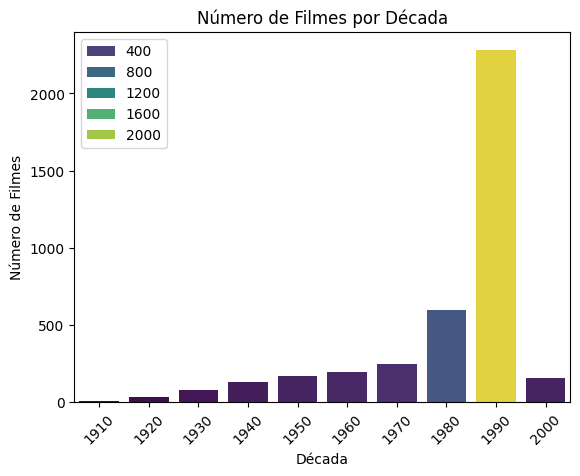

In [11]:
movies['Decade'] = (movies['Year'] // 10) * 10
movies_per_decade = movies['Decade'].value_counts().sort_index()

sns.barplot(x=movies_per_decade.index, y=movies_per_decade.values, hue=movies_per_decade.values, palette="viridis")
plt.title('Número de Filmes por Década')
plt.xlabel('Década')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.show()

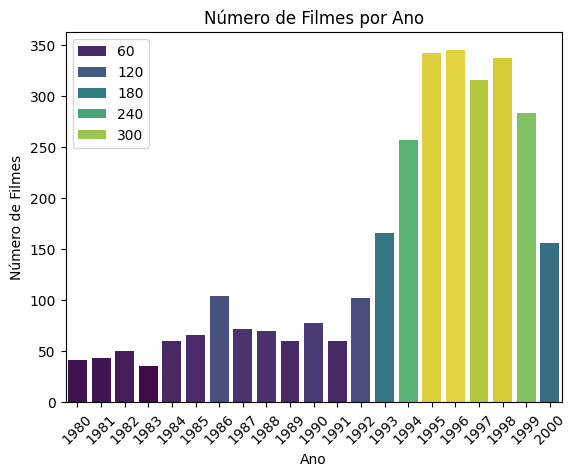

In [12]:
# Analisar filmes por ano a partir da década de 80
movies_per_year = movies[movies['Year'] >= 1980]['Year'].value_counts().sort_index()

sns.barplot(x=movies_per_year.index, y=movies_per_year.values, hue=movies_per_year.values, palette="viridis")
plt.title('Número de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45)
plt.show()

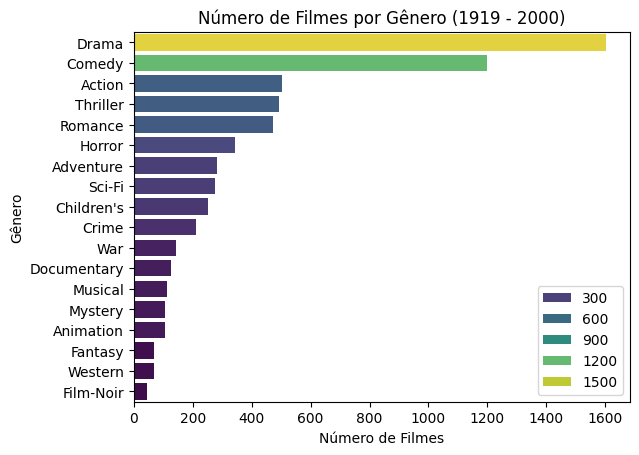

In [13]:
genres = movies['Genres'].str.get_dummies(sep='|')
genre_counts = genres.sum().sort_values(ascending=False)
sns.barplot(y=genre_counts.index, x=genre_counts.values, hue=genre_counts.values, palette="viridis")
plt.title('Número de Filmes por Gênero (1919 - 2000)')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

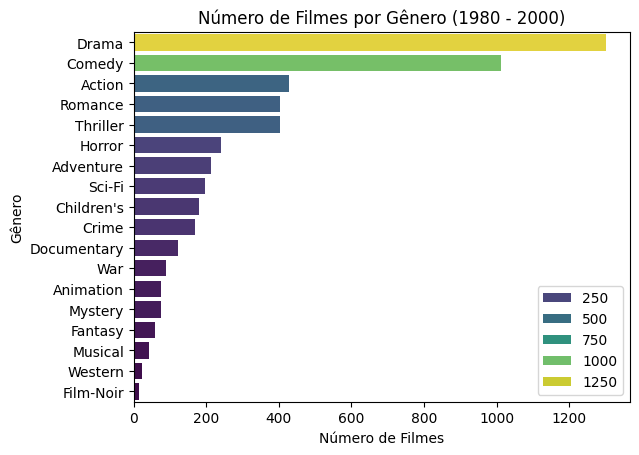

In [14]:
genres = movies[movies['Year'] >= 1980]['Genres'].str.get_dummies(sep='|')
genre_counts = genres.sum().sort_values(ascending=False)
sns.barplot(y=genre_counts.index, x=genre_counts.values, hue=genre_counts.values, palette="viridis")
plt.title('Número de Filmes por Gênero (1980 - 2000)')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

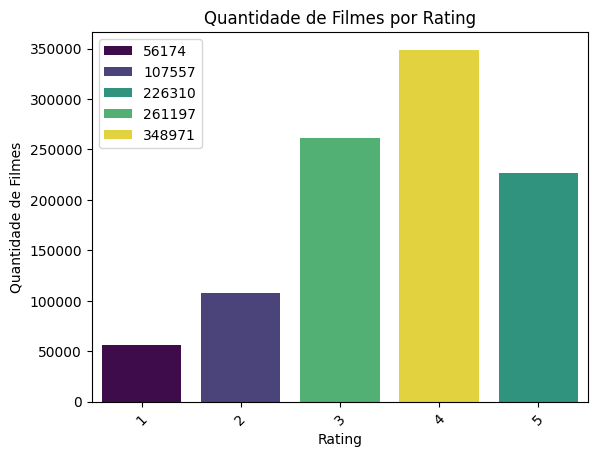

In [15]:
rating_counts = ratings['Rating'].value_counts().sort_index()

sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.values, palette="viridis")
plt.title('Quantidade de Filmes por Rating')
plt.xlabel('Rating')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=45)
plt.show()

## Pré-processamento dos dados

Não temos nenhum filme duplicado. Temos filmes relançados, com o mesmo título mas alguns anos de diferença. 

Coluna de gênero agora é um array contendo os gêneros.

Pegar o DataFrame de ratings e calcular uma média entre as avaliações dos usuários pelo ID do filme. Associar aos filmes, no DataFrame de movies, e excluir os filmes que não tiverem avaliação.

In [16]:
movies_duplicates = movies.duplicated().sum()
ratings_duplicates = ratings.duplicated().sum()
print(f'Filmes duplicados: {movies_duplicates}')
print(f'Avaliações duplicadas: {ratings_duplicates}')

Filmes duplicados: 0
Avaliações duplicadas: 0


In [17]:
movies['Genres'] = movies['Genres'].str.split('|')

In [18]:
average_ratings = ratings.groupby('MovieID')['Rating'].mean().reset_index()
movie_rating = pd.merge(movies, average_ratings, on='MovieID', how='left')
movie_rating.head()

,MovieID,Title,Genres,Year,Decade,Rating
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1990,4.146846
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995,1990,3.201141
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,1990,3.016736
3,4,Waiting to Exhale,"[Comedy, Drama]",1995,1990,2.729412
4,5,Father of the Bride Part II,[Comedy],1995,1990,3.006757


In [19]:
# Excluir filmes que não possuem avaliação
movie_rating.dropna(axis=0, inplace=True)

In [20]:
# Criar uma coluna para cada gênero
def create_genre_column(data: pd.DataFrame):
    exploded = data.explode('Genres')
    dummies = pd.get_dummies(exploded['Genres'])
    df_dummies = dummies.groupby(exploded['MovieID']).sum()
    df_dummies = df_dummies.reset_index()
    return data.drop(columns='Genres').merge(df_dummies, on='MovieID')

final_data = create_genre_column(movie_rating)
final_data.drop('Decade', axis=1, inplace=True)
final_data.head()

,MovieID,Title,Year,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,4.146846,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,3.201141,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,3.016736,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,2.729412,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,3.006757,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Cálculo das Matrizes de Distância

Aplicar escala na coluna de ano e de rating para cálculo.

In [21]:
scaler = StandardScaler()
final_data['Year_normalized'] = scaler.fit_transform(final_data[['Year']])
final_data['Rating_normalized'] = scaler.fit_transform(final_data[['Rating']])

feature_columns = final_data.columns[4:]
feature_data = final_data[feature_columns]

# Calcula a matriz de distância euclidiana
distance_matrix = pairwise_distances(feature_data, metric='euclidean')

# Converte a matriz de distância em um DataFrame para melhor visualização
matrix_df = pd.DataFrame(distance_matrix, index=final_data['Title'], columns=final_data['Title'])
matrix_df


Title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Bamboozled,Bootmen,Digimon: The Movie,Get Carter,Get Carter,Meet the Parents,Requiem for a Dream,Tigerland,Two Family House,"Contender, The"
Title,,,,,,,,,,,,,,,,,,,,,
Toy Story,4.214685e-08,2.444501,2.412705,2.727275,2.207078,2.481693,2.048845,2.414807,2.983951,2.609985,...,2.176690,3.499269,4.207400,3.735612,2.662724,1.633283,2.023060e+00,2.144731,2.055516,2.320845e+00
Jumanji,2.444501e+00,0.000000,2.252802,2.343406,2.020759,2.648427,2.257610,1.037679,2.157400,2.062632,...,2.034608,2.777614,2.927568,2.836743,2.499841,2.123146,2.436360e+00,2.137582,2.273633,2.415179e+00
Grumpier Old Men,2.412705e+00,2.252802,0.000000,1.477281,1.000110,2.577070,0.585202,2.000002,1.812754,2.367714,...,1.045615,1.975406,3.201626,2.521012,2.354905,1.391731,2.399078e+00,2.005898,2.194052,2.319601e+00
Waiting to Exhale,2.727275e+00,2.343406,1.477281,0.000000,1.081625,2.813864,1.739146,2.044454,1.735404,2.540340,...,1.149147,0.966964,2.914227,1.891371,2.511326,1.704408,2.309156e+00,1.740973,2.029141,2.129072e+00
Father of the Bride Part II,2.207078e+00,2.020759,1.000110,1.081625,0.000000,2.383173,1.166208,1.732091,1.506795,2.151600,...,0.308364,1.691899,3.030387,2.307023,2.136797,0.982052,2.191854e+00,1.747141,1.962913,2.101061e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents,1.633283e+00,2.123146,1.391731,1.704408,0.982052,2.054502,1.096644,1.985567,2.051126,2.027453,...,0.867447,2.476814,3.766399,2.860196,2.259381,0.000000,1.583562e+00,1.414961,1.467743,1.745442e+00
Requiem for a Dream,2.023060e+00,2.436360,2.399078,2.309156,2.191854,2.052804,2.046305,2.401133,2.605373,2.195414,...,2.120439,3.141867,4.386502,3.098726,2.440840,1.583562,2.980232e-08,0.666531,0.319739,1.116567e+00
Tigerland,2.144731e+00,2.137582,2.005898,1.740973,1.747141,2.046920,1.798757,2.007353,2.083991,2.031179,...,1.683551,2.518947,3.805438,2.524056,2.264772,1.414961,6.665313e-01,0.000000,0.346792,1.014317e+00


## Algoritmos de Clusterização

### K-Means

Usar o Elbow Method e o Silhouette Coefficient para achar o número ideal de Clusters.

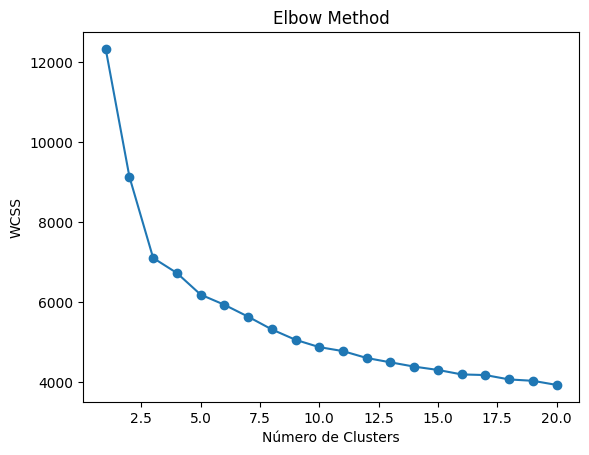

In [22]:
X = final_data[feature_columns]
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do Método do Cotovelo
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

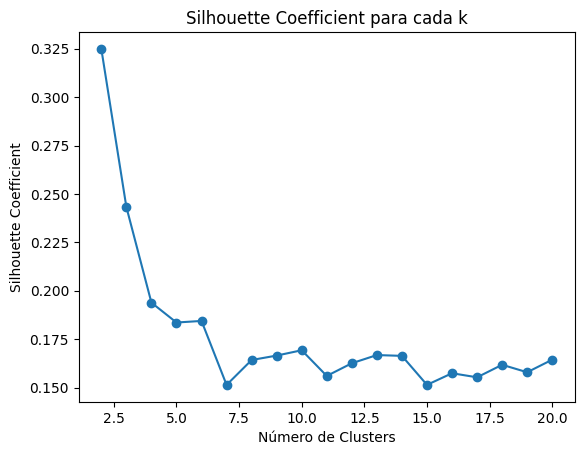

In [23]:
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Coeficiente de Silhueta
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient para cada k')
plt.show()

In [24]:
# Ver resultados top 10 resultados de cada Cluster - k=4
X = final_data[feature_columns]
cluster = final_data.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
cluster['Cluster'] = kmeans.fit_predict(X)
for k in range(4):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster 0--------------------------------
978     To Gillian on Her 37th Birthday
1670        I Love You, Don't Touch Me!
611                        Carried Away
1469                    She's So Lovely
1038                       Funeral, The
1514            Telling Lies in America
2566                   Brokedown Palace
924                               Bliss
1481                          Star Maps
932                   Last Man Standing
Name: Title, dtype: object
-------------------------Cluster 1--------------------------------
2034                Elstree Calling
2031            Waltzes from Vienna
914         Something to Sing About
3071    With Byrd at the South Pole
916                Moonlight Murder
2572                          Cobra
2935              Bat Whispers, The
3089                Happy Go Lovely
2035               Juno and Paycock
2844                       Ape, The
Name: Title, dtype: object
-------------------------Cluster 2------------------

### DBSCAN

No DBSCAN podemos ver que teve o retorno de 4 clusters, batendo com o resultado que tivemos no K-Means. Também tivemos alguns filmes no cluster -1, que são prováveis outliers. Além disso, é possível ver algumas sequências de filmes no mesmo cluster, um indicativo que estamos detectando realmente alguma similaridade.

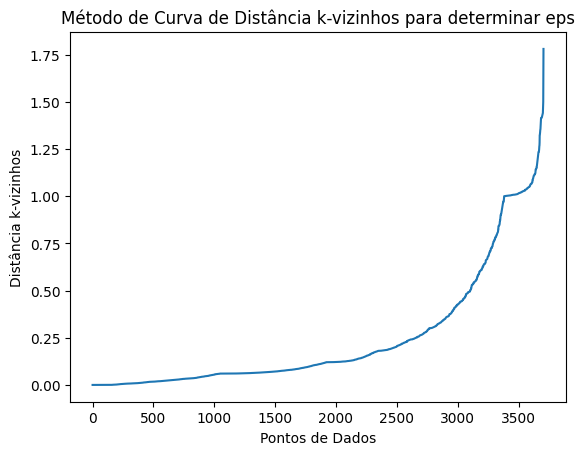

In [25]:
# Determinar o valor de eps usando k-nearest neighbors
X = final_data[feature_columns]
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordenar as distâncias dos k-vizinhos
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância k-vizinhos')
plt.title('Método de Curva de Distância k-vizinhos para determinar eps')
plt.show()

In [26]:
# Aplicar o DBSCAN com eps e min_samples escolhidos
eps = 1
min_samples = 50
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
X = final_data[feature_columns]
cluster = final_data.copy()
cluster['Cluster'] = dbscan.fit_predict(X)
for k in range(-1, 5):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster -1--------------------------------
3658                                  Uninvited Guest, An
3409    Blood Spattered Bride, The (La Novia Ensangren...
658                                               Windows
696                                         Low Life, The
774                                             Diebinnen
791                                            Lotto Land
1062                                          Get Over It
1287                               Terror in a Texas Town
1078                                    Bloody Child, The
2031                                  Waltzes from Vienna
Name: Title, dtype: object
-------------------------Cluster 0--------------------------------
633                                       Mutters Courage
621     Little Indian, Big City (Un indien dans la ville)
3006                                       Wirey Spindell
2907                 Spring Fever USA (a.k.a. Lauderdale)
1217                      

### Clustering Hierárquico (Agglomerative)

In [27]:
X = final_data[feature_columns]
agg_clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
cluster = final_data.copy()
cluster['Cluster'] = agg_clustering.fit_predict(X)
for k in range(5):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster 0--------------------------------
771                           Crude Oasis, The
1568                         Never Met Picasso
662            Promise, The (Versprechen, Das)
3580                        Autumn in New York
173                                   Mad Love
2699                             Random Hearts
3557    Criminal Lovers (Les Amants Criminels)
3116                     And God Created Woman
1344             Beautician and the Beast, The
1498                       Smile Like Yours, A
Name: Title, dtype: object
-------------------------Cluster 1--------------------------------
3089                Happy Go Lovely
3071    With Byrd at the South Pole
3000                     Night Tide
2035               Juno and Paycock
2935              Bat Whispers, The
2572                          Cobra
916                Moonlight Murder
3255         Hideous Sun Demon, The
3684        Giant Gila Monster, The
1073                  Six of a Kind
Name: Tit

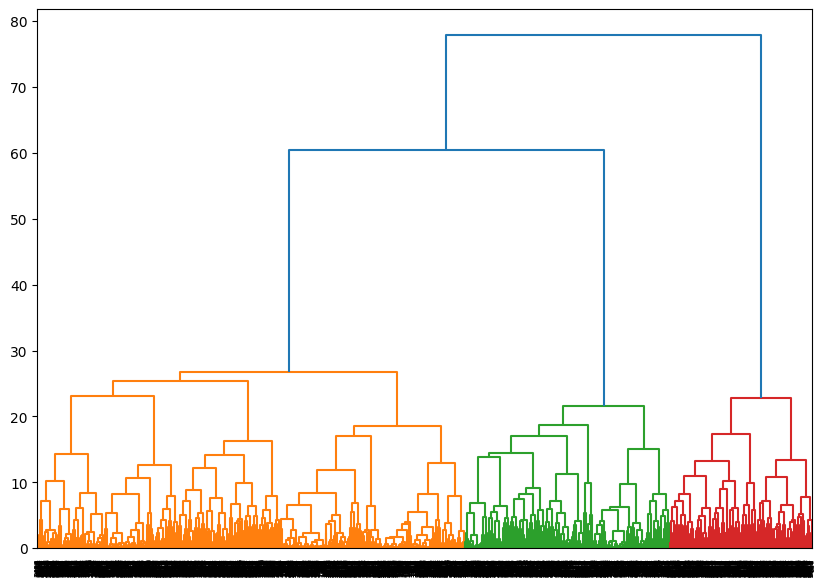

In [28]:
# Visualizar dendrograma
linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

## Análise da Variação de Número de Clusters

Conforme vimos nas experiências com os algoritmos de Clusterização que foram realizadas anteriormente, tivemos uma pequena variação no número de clusters. No K-Means, olhando para o Elbow Method que um número ideal de clusters seria algo entre 3 e 6. Seguindo, vimos o coeficiente de silhueta, que não retornou um valor bom, mas que o ideal seriam 3 ou 4 clusters. Seguindo para o DBSCAN, vimos 4 clusters, sem contar o cluster dos possíveis outliers. Agora no clustering hierárquico, fazendo de forma agregativa, vemos 5 clusters. Portanto, tivemos uma varição desse número, mas uma variação baixa e que nos dá uma noção de onde podemos fazer a separação dos dados. 

## Remoção dos Outliers

Aqui, vou retirar todos os filmes que possuem a data de lançamento antes de 1980.

Remover avaliações que foram realizadas 1 mês depois da primeira avaliação (lançamento do filme) - Foram removidos mais de 900k avaliações.

In [29]:
recent_movies = movies[movies["Year"] >= 1980]

In [30]:
ratings['Timestamp'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [31]:
def filter_by_movie_id(movie_id):
    movie_df = ratings[ratings['MovieID'] == movie_id]
    min_date = movie_df['Timestamp'].min()
    max_date = min_date + pd.DateOffset(months=1)
    filtered = ratings[(ratings['Timestamp'] >= min_date) & (ratings['Timestamp'] < max_date) & (ratings['MovieID'] == movie_id)]
    return filtered

new_ratings = pd.DataFrame()
for movie_id in ratings['MovieID'].unique():
    new_ratings = pd.concat([new_ratings, filter_by_movie_id(movie_id)])

In [32]:
len(new_ratings)

74763

In [33]:
average_ratings = new_ratings.groupby('MovieID')['Rating'].mean().reset_index()
movie_rating = pd.merge(recent_movies, average_ratings, on='MovieID', how='left')
movie_rating.head()
movie_rating.dropna(axis=0, inplace=True)

In [34]:
movie_rating = create_genre_column(movie_rating)
movie_rating.drop('Decade', axis=1, inplace=True)
movie_rating.head()

,MovieID,Title,Year,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,4.194631,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,3.341463,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,2.782609,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,2.750000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,2.818182,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Refazendo Análise

### Sem redução de dimensionalidade

In [35]:
no_dim = movie_rating.copy()
feature_columns = no_dim.columns[4:]
feature_data = no_dim[feature_columns]
# Calcula a matriz de distância euclidiana
distance_matrix = pairwise_distances(feature_data, metric='euclidean')
# Converte a matriz de distância em um DataFrame para melhor visualização
matrix_df = pd.DataFrame(distance_matrix, index=no_dim['Title'], columns=no_dim['Title'])
matrix_df

Title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Sorority House Massacre II,Bamboozled,Bootmen,Digimon: The Movie,Get Carter,Meet the Parents,Requiem for a Dream,Tigerland,Two Family House,"Contender, The"
Title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.000000,2.000000,1.732051,1.732051,1.414214,2.449490,1.732051,1.732051,2.000000,2.449490,...,2.000000,1.414214,1.732051,1.414214,2.449490,1.414214,2.000000,2.000000,2.000000,2.236068
Jumanji,2.000000,0.000000,2.236068,2.236068,2.000000,2.449490,2.236068,1.000000,2.000000,2.000000,...,2.000000,2.000000,2.236068,1.414214,2.449490,2.000000,2.000000,2.000000,2.000000,2.236068
Grumpier Old Men,1.732051,2.236068,0.000000,1.414214,1.000000,2.236068,0.000000,2.000000,1.732051,2.236068,...,1.732051,1.000000,1.414214,2.236068,2.236068,1.000000,1.732051,1.732051,1.732051,2.000000
Waiting to Exhale,1.732051,2.236068,1.414214,0.000000,1.000000,2.236068,1.414214,2.000000,1.732051,2.236068,...,1.732051,1.000000,0.000000,2.236068,1.732051,1.000000,1.000000,1.000000,1.000000,1.414214
Father of the Bride Part II,1.414214,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.732051,1.414214,2.000000,...,1.414214,0.000000,1.000000,2.000000,2.000000,0.000000,1.414214,1.414214,1.414214,1.732051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents,1.414214,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.732051,1.414214,2.000000,...,1.414214,0.000000,1.000000,2.000000,2.000000,0.000000,1.414214,1.414214,1.414214,1.732051
Requiem for a Dream,2.000000,2.000000,1.732051,1.000000,1.414214,2.000000,1.732051,1.732051,1.414214,2.000000,...,1.414214,1.414214,1.000000,2.000000,1.414214,1.414214,0.000000,0.000000,0.000000,1.000000
Tigerland,2.000000,2.000000,1.732051,1.000000,1.414214,2.000000,1.732051,1.732051,1.414214,2.000000,...,1.414214,1.414214,1.000000,2.000000,1.414214,1.414214,0.000000,0.000000,0.000000,1.000000


In [36]:
# Colocando agora o ano e o rating com escala
scaler = StandardScaler()
no_dim_yr = no_dim.copy()
no_dim_yr['Year_normalized'] = scaler.fit_transform(no_dim_yr[['Year']])
no_dim_yr['Rating_normalized'] = scaler.fit_transform(no_dim_yr[['Rating']])
feature_columns = no_dim_yr.columns[4:]
feature_data = no_dim_yr[feature_columns]
# Calcula a matriz de distância euclidiana
distance_matrix = pairwise_distances(feature_data, metric='euclidean')
# Converte a matriz de distância em um DataFrame para melhor visualização
matrix_df = pd.DataFrame(distance_matrix, index=no_dim_yr['Title'], columns=no_dim_yr['Title'])
matrix_df

Title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Sorority House Massacre II,Bamboozled,Bootmen,Digimon: The Movie,Get Carter,Meet the Parents,Requiem for a Dream,Tigerland,Two Family House,"Contender, The"
Title,,,,,,,,,,,,,,,,,,,,,
Toy Story,4.214685e-08,2.233791,2.389824,2.416181,2.139245,2.459982,1.979905,1.782557,2.331728,2.620216,...,4.340458,2.297820,3.397587,3.823529,3.416514,1.765328,2.233988,2.548168,2.244184,2.518045
Jumanji,2.233791e+00,0.000000,2.329099,2.340024,2.091018,2.567045,2.236353,1.152820,2.010360,2.001042,...,3.523742,2.289111,3.009053,2.969060,2.888519,2.307188,2.514073,2.240626,2.341316,2.470893
Grumpier Old Men,2.389824e+00,2.329099,0.000000,1.414725,1.000860,2.648649,0.687411,2.345484,1.789016,2.347981,...,2.877960,1.406009,2.046188,3.014386,2.497195,1.879256,2.695317,2.031938,2.417970,2.454444
Waiting to Exhale,2.416181e+00,2.340024,1.414725,0.000000,1.003156,2.669223,1.589421,2.365570,1.798912,2.359859,...,2.850616,1.409870,1.450567,2.992244,2.048801,1.904822,2.324737,1.470143,1.988075,2.025869
Father of the Bride Part II,2.139245e+00,2.091018,1.000860,1.003156,0.000000,2.428843,1.190472,2.097942,1.471442,2.110761,...,2.730721,0.984022,1.811200,2.869653,2.298079,1.558643,2.472987,1.759705,2.175865,2.222720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents,1.765328e+00,2.307188,1.879256,1.904822,1.558643,2.233663,1.510442,1.990546,1.899951,2.291209,...,4.116642,1.129102,2.563131,3.622885,2.675358,0.000000,1.522693,1.646943,1.419291,1.746235
Requiem for a Dream,2.233988e+00,2.514073,2.695317,2.324737,2.472987,2.262695,2.288790,2.076586,2.199401,2.484795,...,4.585469,2.206375,3.090697,4.105367,2.735344,1.522693,0.000000,1.408492,0.444498,1.272273
Tigerland,2.548168e+00,2.240626,2.031938,1.470143,1.759705,2.445995,2.009731,2.151237,1.721340,2.248535,...,3.469119,1.442655,1.816075,2.956059,1.694195,1.646943,1.408492,0.000000,0.963994,1.177624


### Com redução de Dimensionalidade - PCA 

In [37]:
genres_columns = movie_rating.columns[4:]

scaler = StandardScaler()
genres_data_scaled = scaler.fit_transform(movie_rating[genres_columns])
# Aplicando PCA para reduzir a dimensionalidade para 2 componentes principais
pca = PCA(n_components=2)
genres_pca = pca.fit_transform(genres_data_scaled)
df_pca = pd.DataFrame(genres_pca, columns=['PC1', 'PC2'])
mr_pca = pd.concat([movie_rating[['MovieID', 'Title', 'Year', 'Rating']], df_pca], axis=1)
mr_pca

,MovieID,Title,Year,Rating,PC1,PC2
0,1,Toy Story,1995,4.194631,3.633610,-4.405723
1,2,Jumanji,1995,3.341463,5.539726,-2.076493
2,3,Grumpier Old Men,1995,2.782609,-0.719982,-1.158596
3,4,Waiting to Exhale,1995,2.750000,-1.069951,-0.819629
4,5,Father of the Bride Part II,1995,2.818182,-0.306892,-0.790239
...,...,...,...,...,...,...
2891,3948,Meet the Parents,2000,3.857143,-0.306892,-0.790239
2892,3949,Requiem for a Dream,2000,4.341176,-0.971794,-0.109215
2893,3950,Tigerland,2000,3.133333,-0.971794,-0.109215
2894,3951,Two Family House,2000,3.960000,-0.971794,-0.109215


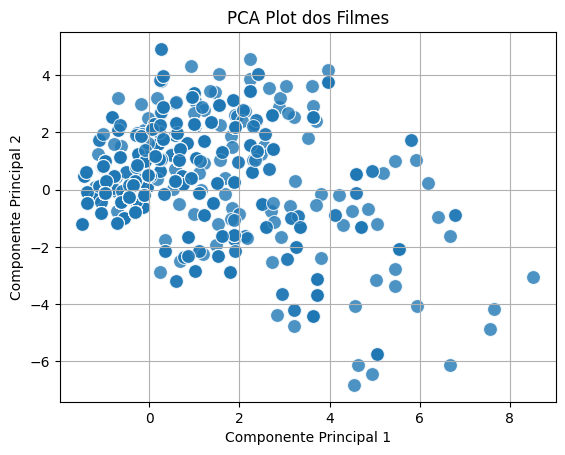

In [38]:
sns.scatterplot(x='PC1', y='PC2', data=mr_pca, s=100, alpha=0.8)
plt.title('PCA Plot dos Filmes')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

### Rodando o K-Means, DBSCAN com redução de dimensionalidade

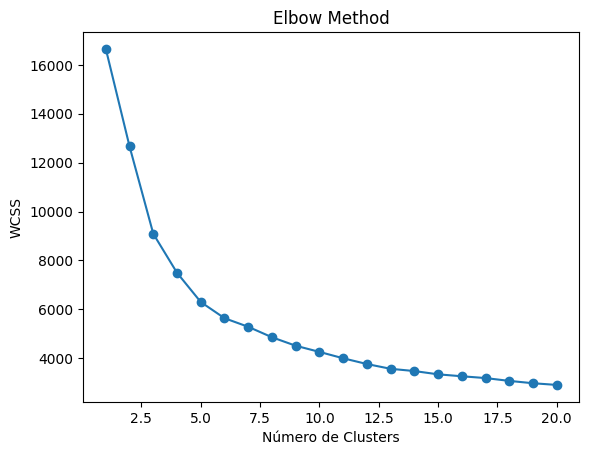

In [39]:
reduction = mr_pca.copy()
reduction['Year_normalized'] = scaler.fit_transform(reduction[['Year']])
reduction['Rating_normalized'] = scaler.fit_transform(reduction[['Rating']])
columns = reduction.columns[4:]
X = reduction[columns]
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do Método do Cotovelo
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

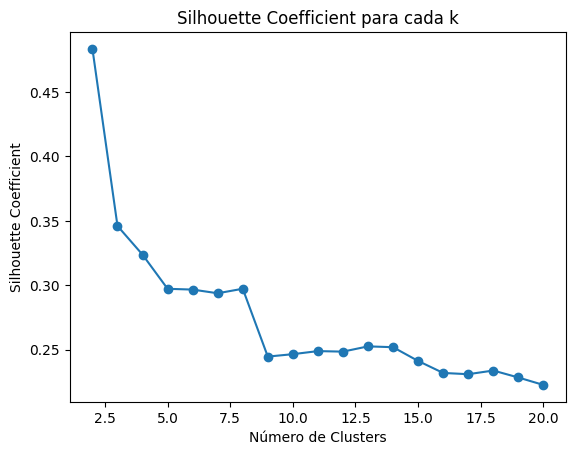

In [40]:
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Coeficiente de Silhueta
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient para cada k')
plt.show()

Rodamos com 4 clusters.

In [41]:
# Ver resultados top 10 resultados de cada Cluster - k=4
X = reduction[columns]
cluster = reduction.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
cluster['Cluster'] = kmeans.fit_predict(X)
for k in range(4):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster 0--------------------------------
1105                                 Meet Wally Sparks
1007                                Santa with Muscles
901                                  Talking About Sex
915                                  Bloody Child, The
885                                          Sleepover
1311                             Chairman of the Board
2782    Wisdom of Crocodiles, The (a.k.a. Immortality)
906                                        Get Over It
803                                      Venice/Venice
807                                   Dangerous Ground
Name: Title, dtype: object
-------------------------Cluster 1--------------------------------
136                         Shadows (Cienie)
2886              Sorority House Massacre II
2885                 Sorority House Massacre
2251                         Penitentiary II
1016                          Amityville 3-D
1023                             Blood Beach
2220    And the Shi

Rodando o DBSCAN foram retornados 8 clusters

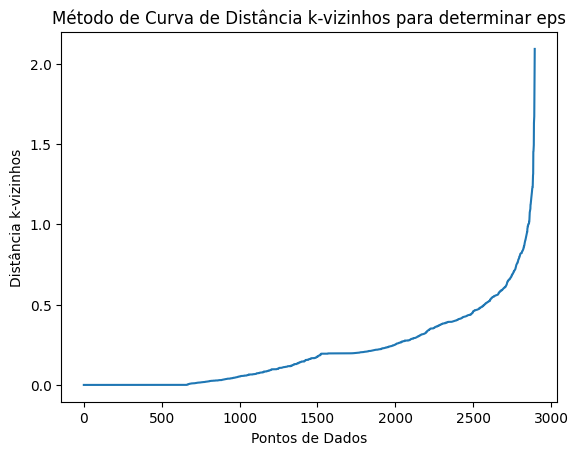

In [42]:
# Determinar o valor de eps usando k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordenar as distâncias dos k-vizinhos
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância k-vizinhos')
plt.title('Método de Curva de Distância k-vizinhos para determinar eps')
plt.show()

In [43]:
# Aplicar o DBSCAN com eps e min_samples escolhidos
eps = 0.5
min_samples = 30
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
X = final_data[feature_columns]
cluster = final_data.copy()
cluster['Cluster'] = dbscan.fit_predict(X)
for k in range(-1, 8):
    print(f'-------------------------Cluster {k}--------------------------------')
    print(cluster[cluster['Cluster'] == k].sort_values(by='Rating')['Title'][:10])

-------------------------Cluster -1--------------------------------
128                                       Nueba Yol
122     Silence of the Palace, The (Saimt el Qusur)
1326                                     Underworld
137                                Shadows (Cienie)
2638                                     White Boys
1287                         Terror in a Texas Town
1217                             Santa with Muscles
1858                                        Cheetah
3006                                 Wirey Spindell
3013                    Kestrel's Eye (Falkens öga)
Name: Title, dtype: object
-------------------------Cluster 0--------------------------------
1344    Beautician and the Beast, The
1498              Smile Like Yours, A
3376                            Loser
2792                    Bachelor, The
433                        Favor, The
1616                      Little City
1357                       Booty Call
2677                         Dog Park
2192          

### Matriz diagonal da decomposição SVD

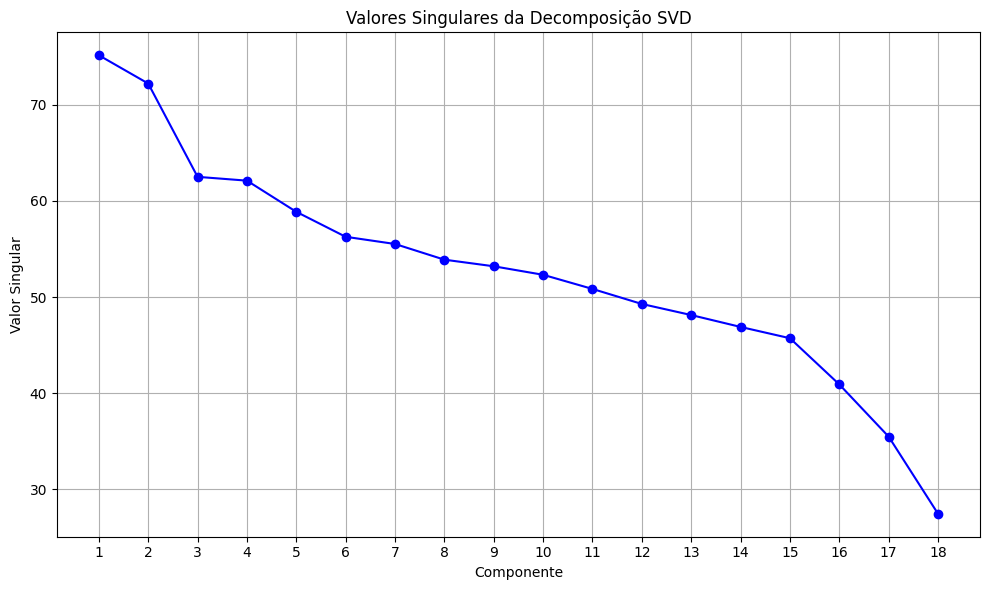

In [44]:
genres_data_scaled = scaler.fit_transform(movie_rating[genres_columns])

# Aplicando a SVD para reduzir a dimensionalidade para o número de componentes igual ao número de colunas de gêneros
svd = TruncatedSVD(n_components=len(genres_columns))
svd.fit(genres_data_scaled)

# Plotando os valores singulares (matriz diagonal Sigma)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(svd.singular_values_) + 1), svd.singular_values_, marker='o', linestyle='-', color='b')
plt.title('Valores Singulares da Decomposição SVD')
plt.xlabel('Componente')
plt.ylabel('Valor Singular')
plt.xticks(np.arange(1, len(svd.singular_values_) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusão

